In [1]:
import numpy as np
import nengo
from nengo import Lowpass
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io
from model import DotPerception, detect_extrema_dot_motion
import pyreadr
import rdata
import json
palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

# Model

In [2]:
def build_network(inputs, nActions=2, nNeurons=50, synapse=0.1, seed=0, ramp=1, threshold=0.3, relative=0,
        max_rates=nengo.dists.Uniform(60, 80), rA=1, spike_filter=0.03, w_accumulator=None, w_gate=None, w_or_d=None):
    
    net = nengo.Network(seed=seed)
    net.config[nengo.Connection].synapse = 0.03
    net.config[nengo.Probe].synapse = 0.03
    net.config[nengo.Ensemble].max_rates = max_rates

    # references
    net.inputs = inputs
    net.seed = seed
    net.synapse = synapse
    net.nNeurons = nNeurons

    net.ramp = ramp
    net.threshold = threshold
    net.relative = relative

    func_input = lambda t: net.inputs.sample(t)
    func_threshold = lambda t: net.threshold
    func_ramp = lambda x: net.synapse * net.ramp * x
    func_value = lambda x: [x[0]-x[1]*net.relative, x[1]-x[0]*net.relative]  # raw evidence vs relative advantage

    ePos = nengo.dists.Choice([[1]])
    iPos = nengo.dists.Uniform(0, 1)

    with net:
        # Inputs
        environment = nengo.Node(func_input)
        threshold = nengo.Node(func_threshold)
        # Ensembles
        perception = nengo.Ensemble(nNeurons, nActions)
        accumulator = nengo.Ensemble(nNeurons, nActions, radius=rA)
        value = nengo.Ensemble(nNeurons, nActions, radius=net.threshold)
        gate = nengo.Ensemble(nNeurons, 1, encoders=ePos, intercepts=iPos)
        action = nengo.networks.EnsembleArray(nNeurons, nActions, encoders=ePos, intercepts=iPos)
        # Connections
        nengo.Connection(environment, perception)  # external inputs
        nengo.Connection(perception, accumulator, synapse=net.synapse, function=func_ramp)  # send percepts to accumulator
        # nengo.Connection(accumulator, accumulator, synapse=net.synapse) # recurrent connection for accumulation
        nengo.Connection(accumulator, value, function=func_value)  # compute value from evidence in accumulator
        nengo.Connection(value, action.input)
        nengo.Connection(threshold, gate)  # external inputs
        # nengo.Connection(gate, action.input, transform=-1*np.ones((nActions, 1)))  # inhibition via decision criteria
        if w_or_d=='save':
            conn_accumulator = nengo.Connection(accumulator, accumulator, synapse=net.synapse, seed=seed) # recurrent cortical connection for accumulation    
            conn_gate0 = nengo.Connection(gate, action.ea_ensembles[0], transform=-1, seed=seed)  # inhibition via decision criteria, corticostriatal white matter
            conn_gate1 = nengo.Connection(gate, action.ea_ensembles[1], transform=-1, seed=seed)  # inhibition via decision criteria, corticostriatal white matter
        elif w_or_d=="d":
            conn_accumulator = nengo.Connection(accumulator.neurons, accumulator, synapse=net.synapse, transform=w_accumulator, seed=seed)
            conn_gate0 = nengo.Connection(gate.neurons, action.ea_ensembles[0], transform=w_gate[0], seed=seed)
            conn_gate1 = nengo.Connection(gate.neurons, action.ea_ensembles[1], transform=w_gate[1], seed=seed)
        elif w_or_d=="w":
            conn_accumulator = nengo.Connection(accumulator.neurons, accumulator.neurons, synapse=net.synapse, transform=w_accumulator, seed=seed)
            conn_gate0 = nengo.Connection(gate.neurons, action.ea_ensembles[0].neurons, transform=w_gate[0], seed=seed)
            conn_gate1 = nengo.Connection(gate.neurons, action.ea_ensembles[1].neurons, transform=w_gate[1], seed=seed)
        # Probes
        net.pInputs = nengo.Probe(environment, synapse=None)
        net.pPerception = nengo.Probe(perception)
        net.pAccumulator = nengo.Probe(accumulator)
        net.pValue = nengo.Probe(value)
        net.pGate = nengo.Probe(gate)
        net.pAction = nengo.Probe(action.output)
        net.pSpikes = nengo.Probe(value.neurons, synapse=spike_filter)
        net.accumulator = accumulator
        net.gate = gate
        net.value = value
        net.action = action
        net.conn_accumulator = conn_accumulator
        net.conn_gate0 = conn_gate0
        net.conn_gate1 = conn_gate1

    return net

## Age Manipulation

In [3]:
def age_weights(net, sim, w_or_d, degrade_accumulator, degrade_gate, seed=0):
    rng = np.random.RandomState(seed=seed)
    if w_or_d=="d":
        # grab decoders
        d_acc = sim.data[net.conn_accumulator].weights.copy()  # decoders
        d_gate0 = sim.data[net.conn_gate0].weights.copy()  # decoders
        d_gate1 = sim.data[net.conn_gate1].weights.copy()  # decoders
        # choose random indices
        idx_acc = rng.choice(range(d_acc.shape[1]), size=int(degrade_accumulator*d_acc.shape[1]), replace=False)
        idx_gate0 = rng.choice(range(d_gate0.shape[1]), size=int(degrade_gate*d_gate0.shape[1]), replace=False)
        idx_gate1 = rng.choice(range(d_gate1.shape[1]), size=int(degrade_gate*d_gate1.shape[1]), replace=False)
        # set those indices to zero
        d_acc[:,idx_acc] = 0
        d_gate0[:,idx_gate0] = 0
        d_gate1[:,idx_gate1] = 0
        return d_acc, [d_gate0, d_gate1]
    if w_or_d=="w":
        # grab decoders and encoders
        d_acc = sim.data[net.conn_accumulator].weights.copy()  # decoders
        d_gate0 = sim.data[net.conn_gate0].weights.copy()  # decoders
        d_gate1 = sim.data[net.conn_gate1].weights.copy()  # decoders
        e_acc = sim.data[net.accumulator].encoders.copy()  # encoders
        e_action0 = sim.data[net.action.ea_ensembles[0]].encoders.copy()  # encoders
        e_action1 = sim.data[net.action.ea_ensembles[1]].encoders.copy()  # encoders
        # compute weight matrices
        w_acc = e_acc @ d_acc
        w_gate0 = e_action0 @ d_gate0
        w_gate1 = e_action1 @ d_gate1
        # choose random indices by flattening weight matrix and picking uniformally
        flat_acc = w_acc.ravel().copy()
        flat_gate0 = w_gate0.ravel().copy()
        flat_gate1 = w_gate1.ravel().copy()
        idx_acc = rng.choice(range(flat_acc.shape[0]), size=int(degrade_accumulator*flat_acc.shape[0]), replace=False)
        idx_gate0 = rng.choice(range(flat_gate0.shape[0]), size=int(degrade_gate*flat_gate0.shape[0]), replace=False)
        idx_gate1 = rng.choice(range(flat_gate1.shape[0]), size=int(degrade_gate*flat_gate1.shape[0]), replace=False)
        # set those indices to zero, and reshape the weight matrix to its original shape
        flat_acc[idx_acc] = 0
        flat_gate0[idx_gate0] = 0
        flat_gate1[idx_gate1] = 0
        W_acc = flat_acc.reshape(w_acc.shape)
        W_gate0 = flat_gate0.reshape(w_gate0.shape)
        W_gate1 = flat_gate1.reshape(w_gate1.shape)
        return W_acc, [W_gate0, W_gate1]

## Sanity check for weight manipulations

In [4]:
coherence=0.2
degrade_accumulator=0.05
degrade_gate=0.1
w_or_d="w"
emphases=['speed', 'accuracy']
ages=['young', 'old']
ramp=1.0
threshold=0.4
relative=0.0
sigma=0.1
nActions=2
nNeurons=50
max_rates=nengo.dists.Uniform(60, 80)
rA=1.0
perception_seed=1
dt=0.001
dt_sample=0.03
tmin=0.1
tmax=3
pid=None

trial = 0

inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
inputs.create(coherence=coherence)
net_young = build_network(inputs, w_or_d='save', nActions=nActions, nNeurons=nNeurons, rA=rA, seed=trial,
                          max_rates=max_rates, ramp=ramp, threshold=threshold, relative=relative)
sim_young = nengo.Simulator(net_young, progress_bar=False)
choice = None
while choice==None:
    sim_young.run(dt)
    tnow = sim_young.trange()[-1]
    if np.any(sim_young.data[net_young.pAction][-1,:] > 0.01) and tnow>tmin:
        choice = np.argmax(sim_young.data[net_young.pAction][-1,:])
        RT = tnow
    if sim_young.trange()[-1] > tmax:
        choice = np.argmax(sim_young.data[net_young.pValue][-1,:])
        RT = tnow
print('RT young', RT)

w_acc, w_gate = age_weights(net_young, sim_young, w_or_d, degrade_accumulator, degrade_gate, seed=perception_seed)

inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
inputs.create(coherence=coherence)
net_old = build_network(inputs, w_or_d=w_or_d, w_accumulator=w_acc, w_gate=w_gate,
                        nActions=nActions, nNeurons=nNeurons, rA=rA, seed=trial,
                        max_rates=max_rates, ramp=ramp, threshold=threshold, relative=relative)
sim_old = nengo.Simulator(net_old, progress_bar=False)
choice = None
while choice==None:
    sim_old.run(dt)
    tnow = sim_old.trange()[-1]
    if np.any(sim_old.data[net_old.pAction][-1,:] > 0.01) and tnow>tmin:
        choice = np.argmax(sim_old.data[net_old.pAction][-1,:])
        RT = tnow
    if sim_old.trange()[-1] > tmax:
        choice = np.argmax(sim_old.data[net_old.pValue][-1,:])
        RT = tnow
print('RT old', RT)

RT young 0.84
RT old 0.973


## Simulation loop

In [5]:
def simulate(
        trials=1,
        coherence=0.2,
        degrade_accumulator=0.0,
        degrade_gate=0.0,
        w_or_d="w",
        emphases=['speed', 'accuracy'],
        ages=['young', 'old'],
        ramp=1.0,
        threshold_speed=0.4,
        threshold_accuracy=0.5,
        relative=0.0,
        sigma=0.1,
        nActions=2,
        nNeurons=50,
        max_rates=nengo.dists.Uniform(60, 80),
        rA=1.0,
        perception_seed=1,
        dt=0.001,
        dt_sample=0.03,
        tmin=0.1,
        tmax=2,
        pid=None,
        name="forstmann_default"):
    
    columns = ['type', 'pid', 'age', 'emphasis', 'trial', 'error', "RT"]
    dfs = []
    for e, emphasis in enumerate(emphases):
        inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
        inputs.create(coherence=coherence)
        if emphasis=='speed': threshold = threshold_speed
        if emphasis=='accuracy': threshold = threshold_accuracy
        print(f"emphasis {emphasis}")
        for task_trial in range(trials):
            if 'young' in ages:
                net_young = build_network(inputs, w_or_d='save', nActions=nActions, nNeurons=nNeurons, rA=rA, seed=task_trial,
                                          max_rates=max_rates, ramp=ramp, threshold=threshold, relative=relative)
                sim_young = nengo.Simulator(net_young, progress_bar=False)
                choice = None
                while choice==None:
                    sim_young.run(dt)
                    tnow = sim_young.trange()[-1]
                    if np.any(sim_young.data[net_young.pAction][-1,:] > 0.01) and tnow>tmin:
                        choice = np.argmax(sim_young.data[net_young.pAction][-1,:])
                        RT = tnow
                    if sim_young.trange()[-1] > tmax:
                        choice = np.argmax(sim_young.data[net_young.pValue][-1,:])
                        RT = tnow
                error = 0 if choice==inputs.correct else 100
                dfs.append(pd.DataFrame([['model', pid, 'young', emphasis, task_trial, error, RT]], columns=columns))

            if 'old' in ages:
                # effectively "age" the model from a functional, young model to an impaired "elderly" model
                w_acc, w_gate = age_weights(net_young, sim_young, w_or_d, degrade_accumulator, degrade_gate, seed=perception_seed)
                net_old = build_network(inputs, w_or_d=w_or_d, w_accumulator=w_acc, w_gate=w_gate,
                                        nActions=nActions, nNeurons=nNeurons, rA=rA, seed=task_trial,
                                        max_rates=max_rates, ramp=ramp, threshold=threshold, relative=relative)
                sim_old = nengo.Simulator(net_old, progress_bar=False)
                choice = None
                while choice==None:
                    sim_old.run(dt)
                    tnow = sim_old.trange()[-1]
                    if np.any(sim_old.data[net_old.pAction][-1,:] > 0.01) and tnow>tmin:
                        choice = np.argmax(sim_old.data[net_old.pAction][-1,:])
                        RT = tnow
                    if sim_old.trange()[-1] > tmax:
                        choice = np.argmax(sim_old.data[net_old.pValue][-1,:])
                        RT = tnow
                        error = 0 if choice==inputs.correct else 100
                dfs.append(pd.DataFrame([['model', pid, 'old', emphasis, task_trial, error, RT]], columns=columns))
    
    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")

In [6]:
def simulate_extrema(
        emphasis='speed',
        age='young',
        pid=None,
        threshold=0.4,
        coherence=0.1,
        nd_mean=0.0,
        nd_sigma=0.0,
        sigma=0.3,
        nActions=2,
        trials=10,
        perception_seed=0,
        network_seed=0,
        dt_sample=0.01,
        tmax=1.5,
        name="forstmann_extrema"):
    
    rng = np.random.RandomState(seed=network_seed)
    columns = ['type', 'age', 'pid', 'emphasis', 'trial', 'error', "RT"]
    dfs = []
    inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed, sigma=sigma)
    inputs.create(coherence=coherence)
    for trial in range(trials):
        choice, RT = detect_extrema_dot_motion(inputs, threshold,
            tiebreaker="random", tmax=tmax, seed=network_seed)
        ndt = rng.normal(nd_mean, nd_sigma)
        ndt = np.max([0, ndt])
        RT += ndt  # add non-decision time to model's RT
        RT = np.min([tmax, RT])
        error = 0 if choice==inputs.correct else 100
        dfs.append(pd.DataFrame([['extrema', age, pid, emphasis, trial, error, RT]], columns=columns))
 
    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")

# Plot

In [7]:
def plot_speed_accuracy(simfile, empfile, extrfile):
    sim = pd.read_pickle(f"data/{simfile}.pkl")
    emp = pd.read_pickle(f"data/{empfile}.pkl")
    extr = pd.read_pickle(f"data/{extrfile}.pkl")
    combined = pd.concat([sim, emp, extr])
    ages = ['young', 'old']
    emphases = ['speed', 'accuracy']
    combined = combined.query("emphasis in @emphases")
    # palette2 = sns.color_palette("tab10")[2:4]
    palette2 = palette[:2]

    fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey='row', figsize=((7, 5)))
    sns.barplot(data=combined.query("type=='human'"), x='emphasis', y='RT', hue='age', order=emphases,
                hue_order=ages, palette=palette2, ax=axes[0][0])
    sns.barplot(data=combined.query("type=='model'"), x='emphasis', y='RT', hue='age', order=emphases,
                hue_order=ages, palette=palette2, ax=axes[0][1])
    sns.barplot(data=combined.query("type=='extrema'"), x='emphasis', y='RT', hue='age', order=emphases,
                hue_order=ages, palette=palette2, ax=axes[0][2])
    sns.barplot(data=combined.query("type=='human'"), x='emphasis', y='error', hue='age', order=emphases,
                hue_order=ages, palette=palette2, ax=axes[1][0])
    sns.barplot(data=combined.query("type=='model'"), x='emphasis', y='error', hue='age', order=emphases,
                hue_order=ages, palette=palette2, ax=axes[1][1])
    sns.barplot(data=combined.query("type=='extrema'"), x='emphasis', y='error', hue='age', order=emphases,
                hue_order=ages, palette=palette2, ax=axes[1][2])
    axes[0][0].set(ylabel="Response Time (s)", title="Human")
    axes[0][1].set(title="Model")
    axes[0][2].set(title="Extrema")
    axes[1][0].set(xlabel="Emphasis", ylabel="Errors (%)", yticks=[0,10,20,30,40])
    axes[0][1].get_legend().remove()
    axes[0][2].get_legend().remove()
    axes[1][0].get_legend().remove()
    axes[1][1].get_legend().remove()
    axes[1][2].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/forstmann_speed_accuracy.svg")
    fig.savefig(f"plots/forstmann_speed_accuracy.png", dpi=600)

In [8]:
def plot_RTs(simfile, empfile, extrfile, bins = np.arange(0.0, 1.7, 0.05)):
    sim = pd.read_pickle(f"data/{simfile}.pkl")
    emp = pd.read_pickle(f"data/{empfile}.pkl")
    extr = pd.read_pickle(f"data/{extrfile}.pkl")
    combined = pd.concat([sim, emp, extr])
    order = ['speed', 'accuracy']
    combined = combined.query("emphasis in @order")
    
    fig = sns.FacetGrid(combined, col='age', hue='type', row="emphasis", row_order=order, legend_out=False,
                        hue_order=['human', 'model', 'extrema'], palette=palette, height=2, aspect=2)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', bins=bins, common_norm=False, alpha=0.3,
                     kde=True, kde_kws={'bw_adjust': 1, 'cut': 0, 'clip': None},)
    fig.set_xlabels("Response Time (s)")
    fig.add_legend()
    plt.tight_layout()
    fig.savefig(f"plots/forstmann_RTs.svg")
    fig.savefig(f"plots/forstmann_RTs.png", dpi=600)

In [9]:
def plot_individuals(simfile, empfile, extrfile, bins=np.arange(0.2, 1.6, 0.05)):
    sim = pd.read_pickle(f"data/{simfile}.pkl")
    emp = pd.read_pickle(f"data/{empfile}.pkl")
    extr = pd.read_pickle(f"data/{extrfile}.pkl")
    combined = pd.concat([sim, emp, extr], ignore_index=True)
    order = ['speed', 'accuracy']
    combined = combined.query("emphasis in @order")

    fig = sns.FacetGrid(combined.query("age=='young'"), col='type', hue='emphasis', row="pid", hue_order=order, palette=palette, height=2, aspect=1.5)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", bins=bins, common_norm=False, alpha=0.3)
    fig.set_xlabels("Response Time (s)")
    fig.add_legend()
    plt.tight_layout()
    fig.savefig(f"plots/forstmann_RTs_individual_young.svg")
    fig.savefig(f"plots/forstmann_RTs_individual_young.png", dpi=600)

    fig = sns.FacetGrid(combined.query("age=='old'"), col='type', hue='emphasis', row="pid", hue_order=order, palette=palette, height=2, aspect=1.5)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', element="poly", bins=bins, common_norm=False, alpha=0.3)
    fig.set_xlabels("Response Time (s)")
    fig.add_legend()
    plt.tight_layout()
    fig.savefig(f"plots/forstmann_RTs_individual_old.svg")
    fig.savefig(f"plots/forstmann_RTs_individual_old.png", dpi=600)

# Empirical

In [10]:
def format_forstmann_young():
    raw = pyreadr.read_r("data/forstmann.rda")['forstmann']
    dfs = []
    columns = ['type', 'age', 'pid', 'emphasis', 'trial', 'RT', 'error']
    for pid in raw['subjects'].unique():
        if pid=='kh6t': continue  # this pid appears in both young and old data, so skip it
        data = raw.query("subjects==@pid")
        trial = 0
        for _, row in data.iterrows():
            # accuracy = 100 if row['R']==row['S'] else 0
            error = 0 if row['R']==row['S'] else 100
            emphasis = row['E']
            RT = row['rt']
            df = pd.DataFrame([['human', 'young', pid, emphasis, trial, RT, error]], columns=columns)
            dfs.append(df)
            trial += 1
    emp = pd.concat(dfs, ignore_index=True)
    emp.to_pickle("data/forstmann2011_young.pkl")

def format_forstmann_old():
    parsed = rdata.parser.parse_file("data/brown.RData")
    raw = rdata.conversion.convert(parsed)['rawdata']['old']
    dfs = []
    columns = ['type', 'age', 'pid', 'emphasis', 'trial', 'RT', 'error']
    for pid in raw['subj'].unique():
        if pid=='kh6t': continue  # this pid appears in both young and old data, so skip it
        data = raw.query("subj==@pid")
        for _, row in data.iterrows():
            error = 0 if row['correct']==1 else 100
            trial = row['trnr']
            if row['cue'] == 'SN': emphasis = 'speed'
            if row['cue'] == 'AK': emphasis = 'accuracy'
            if row['cue'] == 'NE': emphasis = 'neutral'
            RT = row['RT'] / 1000
            df = pd.DataFrame([['human', 'old', pid, emphasis, trial, RT, error]], columns=columns)
            dfs.append(df)
    emp = pd.concat(dfs, ignore_index=True)
    emp.to_pickle("data/forstmann2011_old.pkl")

def combine_forstmann():
    young = pd.read_pickle(f"data/forstmann2011_young.pkl")
    old = pd.read_pickle(f"data/forstmann2011_old.pkl")
    forstmann = pd.concat([young, old], ignore_index=True)
    forstmann.to_pickle("data/forstmann2011.pkl")

def plot_empirical(empfile):
    emp = pd.read_pickle(f"data/{empfile}.pkl")
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=((7, 5)))
    sns.barplot(data=emp, x='emphasis', y='RT', hue='age', order=['speed', 'neutral', 'accuracy'],
                 palette=palette[:2], ax=axes[0])
    sns.barplot(data=emp, x='emphasis', y='error', hue='age', order=['speed', 'neutral', 'accuracy'],
                 palette=palette[:2], ax=axes[1])
    axes[0].set(xlabel="Emphasis", ylabel="Response Time (s)")
    # axes[0].legend(ncols=2, loc='upper right')
    axes[1].set(xlabel="Emphasis", ylabel="Errors (%)", yticks=[0,10,20,30,40])
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/forstmann_empirical.svg")
    fig.savefig(f"plots/forstmann_empirical.png", dpi=600)

    emp = pd.read_pickle(f"data/{empfile}.pkl")
    order = ['speed', 'accuracy']
    emp = emp.query("emphasis in @order")
    bins=np.arange(0.0, 1.6, 0.05)
    for age in ['young', 'old']:
        fig = sns.FacetGrid(emp.query("age==@age"), hue='emphasis', row="pid", hue_order=order, palette=palette, height=2, aspect=1.5)
        fig.map_dataframe(sns.histplot, x="RT", stat='percent', bins=bins, common_norm=False, alpha=0.3,
                         kde=True, kde_kws={'bw_adjust': 1, 'cut': 1, 'clip': None})
        fig.set_xlabels("Response Time (s)")
        fig.add_legend()
        plt.tight_layout()
        fig.savefig(f"plots/forstmann_empirical_individual_{age}.svg")
        fig.savefig(f"plots/forstmann_empirical_individual_{age}.png", dpi=600)

# format_forstmann_young()
# format_forstmann_old()
# combine_forstmann()

# emp = pd.read_pickle(f"data/forstmann2011.pkl")
# print(emp.query("age=='young'")['pid'].unique())
# print(emp.query("age=='old'")['pid'].unique())

# plot_empirical("forstmann2011")

# Simulations

In [14]:
trials = 100
degrade_accumulator = 0.1
degrade_gate = 0.1
ages = ['young', 'old']
emphases = ['speed', 'accuracy']
w_or_d = 'w'
label = "test"

simulate(
    ages=ages,
    emphases=emphases,
    coherence=0.2,
    trials=trials,
    sigma=0.3,
    threshold_speed=0.2,
    threshold_accuracy=0.4,
    ramp=1.5,
    dt_sample=0.05,
    relative=0.3,
    degrade_accumulator=degrade_accumulator,
    degrade_gate=degrade_gate,
    w_or_d=w_or_d,
    name=f"forstmann_{label}")

simulated = pd.read_pickle(f"data/forstmann_{label}.pkl")

emphasis speed
emphasis accuracy


In [29]:
# trials = 1
# degrade_accumulator = 0.0
# degrade_speed = 0.0
# ages = ['young', 'old']
# emphases = ['speed', 'accuracy']
# weights_or_decoders = 'weights'
# label = "july1two"
# pids = ['as1t', 'bd6t']

# # emp = pd.read_pickle(f"data/forstmann2011.pkl").query("age=='young'")
# emp = pd.read_pickle(f"data/forstmann2011.pkl").query("pid in @pids")
# for pid in emp['pid'].unique():
#     print(pid)
#     with open(f"data/forstmann_optimized_params_june29.json") as f:
#         params = json.load(f)[pid]
#     simulate(
#         ages=ages,
#         emphases=emphases,
#         coherence=params['coherence'],
#         trials=trials,
#         sigma=params['sigma'],
#         threshold=params['threshold'],
#         ramp=params['ramp'],
#         dt_sample=params['dt_sample'],
#         degrade_accumulator=degrade_accumulator,
#         degrade_speed=degrade_speed,
#         speed=params['speed'],
#         relative=params['relative'],
#         weights_or_decoders=weights_or_decoders,
#         nNeurons=50,
#         pid=pid,
#         name=f"forstmann_{pid}_{label}")

# dfs = []
# for pid in emp['pid'].unique():
#     dfs.append(pd.read_pickle(f"data/forstmann_{pid}_{label}.pkl"))
# simulated = pd.concat(dfs, ignore_index=True)
# simulated.to_pickle(f"data/forstmann_{label}.pkl")

In [12]:
trials = 300
tmax = 1.5
ages = ['young', 'old']
emphases = ['speed', 'accuracy']
label = "june30extrema"

emp = pd.read_pickle(f"data/forstmann2011.pkl")
for age in ages:
    for pid in emp.query("age==@age")['pid'].unique():
        if age=='young':
            with open(f"data/forstmann_optimized_params_young_june30extrema.json") as f:
                params = json.load(f)[pid]
        if age=='old':
            with open(f"data/forstmann_optimized_params_old_june30extrema.json") as f:
                params = json.load(f)[pid]
        for emphasis in emphases:
            print(pid, age, emphasis)
            if emphasis=='speed': threshold = params['threshold_speed']
            if emphasis=='accuracy': threshold = params['threshold_accuracy']
            simulate_extrema(
                pid=pid,
                trials=trials,
                emphasis=emphasis,
                age=age,
                threshold=threshold,
                coherence=params['coherence'],
                nd_mean=params['nd_mean'],
                nd_sigma=params['nd_sigma'],
                sigma=params['sigma'],
                dt_sample=params['dt_sample'],
                tmax=tmax,
                name=f"forstmann_extrema_{pid}_{age}_{emphasis}_{label}")

dfs = []
for age in ages:
    for pid in emp.query("age==@age")['pid'].unique():
        for emphasis in emphases:
            dfs.append(pd.read_pickle(f"data/forstmann_extrema_{pid}_{age}_{emphasis}_{label}.pkl"))
extrema = pd.concat(dfs, ignore_index=True)
extrema.to_pickle(f"data/forstmann_{label}.pkl")

as1t young speed
as1t young accuracy
bd6t young speed
bd6t young accuracy
bl1t young speed
bl1t young accuracy
hsft young speed
hsft young accuracy
hsgt young speed
hsgt young accuracy
kd6t young speed
kd6t young accuracy
kd9t young speed
kd9t young accuracy
kmat young speed
kmat young accuracy
ku4t young speed
ku4t young accuracy
na1t young speed
na1t young accuracy
rmbt young speed
rmbt young accuracy
rt2t young speed
rt2t young accuracy
rt3t young speed
rt3t young accuracy
rt5t young speed
rt5t young accuracy
scat young speed
scat young accuracy
ta5t young speed
ta5t young accuracy
vf1t young speed
vf1t young accuracy
zk1t young speed
zk1t young accuracy
br4t old speed
br4t old accuracy
he5t old speed
he5t old accuracy
kf1t old speed
kf1t old accuracy
kj1t old speed
kj1t old accuracy
km1t old speed
km1t old accuracy
rw2t old speed
rw2t old accuracy
sd9t old speed
sd9t old accuracy
si7t old speed
si7t old accuracy
su8t old speed
su8t old accuracy
sw7t old speed
sw7t old accuracy
th8t

In [ ]:
# forstmann_june2425extrema coherence0.1
# forstmann_june26extrema coherence 0.2

# Results

In [ ]:
# june25both
# june26both
# june27both

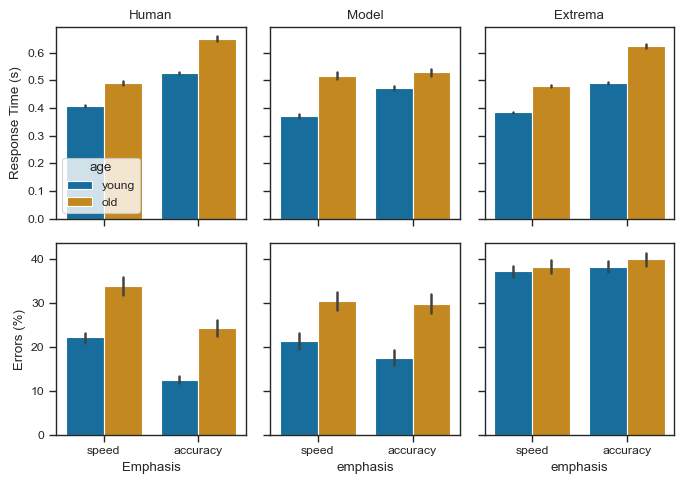

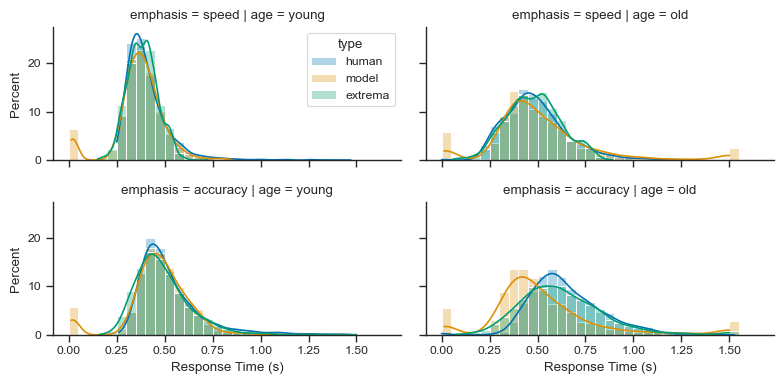

In [38]:
simfile = "forstmann_" + "july1one"
empfile = "forstmann2011"
extrfile = "forstmann_" + "june30extrema"
plot_speed_accuracy(simfile, empfile, extrfile)
plot_RTs(simfile, empfile, extrfile)

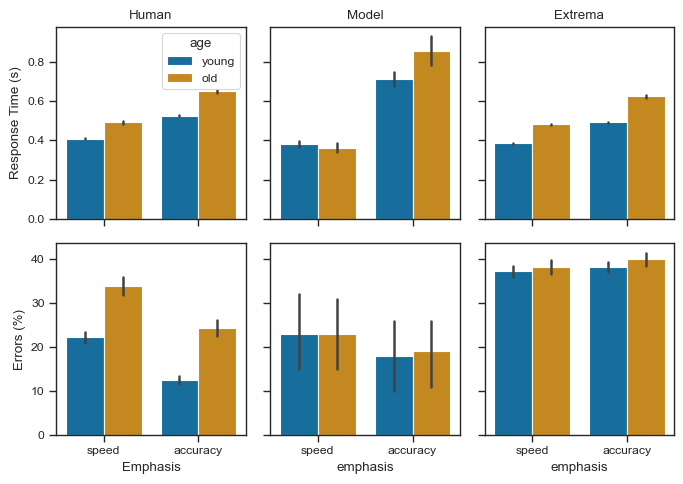

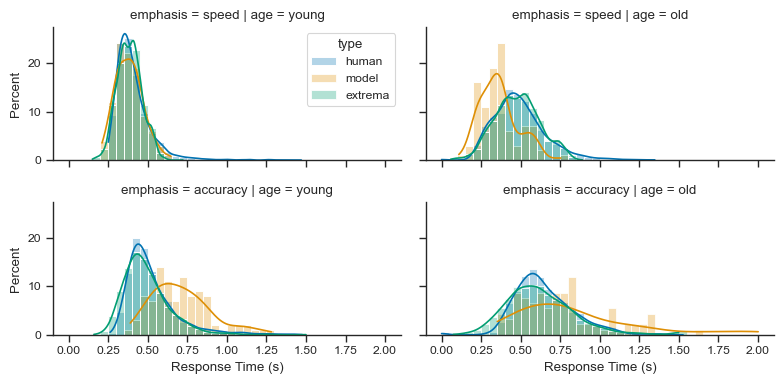

In [15]:
simfile = "forstmann_" + "test"
empfile = "forstmann2011"
extrfile = "forstmann_" + "june30extrema"
plot_speed_accuracy(simfile, empfile, extrfile)
plot_RTs(simfile, empfile, extrfile)

### ETC

In [20]:
def plot_SAT(simfile, empfile, extrfile):
    sim = pd.read_pickle(f"data/{simfile}.pkl")
    emp = pd.read_pickle(f"data/{empfile}.pkl")
    extr = pd.read_pickle(f"data/{extrfile}.pkl")
    combined = pd.concat([sim, emp, extr])
    ages = ['young', 'old']
    emphases = ['speed', 'accuracy']
    combined = combined.query("emphasis in @emphases")
    palette2 = palette[:3]

    dfs = []
    columns = ['pid', 'type', 'emphasis', 'age', 'mean_error', 'mean_RT']
    for pid in combined['pid'].unique():
        for model_type in ['human', 'model', 'extrema']:
            for age in ['young', 'old']:
                for emphasis in ['speed', 'accuracy']:
                    data = combined.query("pid==@pid & type==@model_type & age==@age & emphasis==@emphasis")
                    dfs.append(pd.DataFrame([[pid, model_type, emphasis, age, data['error'].mean(), data['RT'].mean()]], columns=columns))
    df_sat = pd.concat(dfs, ignore_index=True)
    
    fig = sns.FacetGrid(df_sat, col='type', hue='emphasis', row="age", row_order=ages, legend_out=False,
                        col_order=['human', 'model', 'extrema'], hue_order=emphases, palette=palette, height=2, aspect=2)
    fig.map_dataframe(sns.scatterplot, x="mean_RT", y='mean_error')
    fig.set_xlabels("Mean Response Time (s)")
    fig.set_ylabels("Mean Error Rate (%)")
    fig.add_legend()
    plt.tight_layout()
    fig.savefig(f"plots/forstmann_SAT.svg")
    fig.savefig(f"plots/forstmann_SAT.png", dpi=600)

In [25]:
def plot_single(simfile):
    sim = pd.read_pickle(f"data/{simfile}.pkl")
    emp = pd.read_pickle(f"data/forstmann2011.pkl").query("pid=='bd6t'")
    combined = pd.concat([sim, emp])
    order = ['speed', 'accuracy']
    combined = combined.query("emphasis in @order & age=='young'")
    
    bins = np.arange(0, 1.1, 0.05)
    fig = sns.FacetGrid(combined, col='age', hue='type', row="emphasis", row_order=order, legend_out=False,
                        hue_order=['human', 'model'], palette=palette, height=2, aspect=2)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', kde=True, bins=bins, common_norm=False, alpha=0.3,
                     kde_kws={'bw_adjust': 1, 'cut': 2, 'clip': [bins[0], bins[-1]]})
    fig.set_xlabels("Response Time (s)")
    fig.add_legend()
    plt.tight_layout()
    plt.show()
    
    bins = np.arange(0, 1.1, 0.05)
    fig = sns.FacetGrid(combined, hue='emphasis', row="type", hue_order=order, legend_out=False,
                        row_order=['human', 'model'], palette=palette, height=2, aspect=2)
    fig.map_dataframe(sns.histplot, x="RT", stat='percent', kde=True, bins=bins, common_norm=False, alpha=0.3,
                     kde_kws={'bw_adjust': 1, 'cut': 2, 'clip': [bins[0], bins[-1]]})
    fig.set_xlabels("Response Time (s)")
    fig.add_legend()
    plt.tight_layout()
    plt.show()
    
    fig = sns.FacetGrid(combined, col='type', hue='age', col_order=['human', 'model'],
                        legend_out=False, palette=palette, height=2, aspect=2)
    fig.map_dataframe(sns.barplot, x="emphasis", y='error', order=order)
    # fig.set_xlabels("Response Time (s)")
    fig.add_legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# trials = 100
# coherence = 0.24
# dt_sample = 0.04
# ramp = 1.975
# relative = 0.063
# sigma = 0.307
# speed = -0.191
# threshold = 0.513
# tmax = 1.5

# degrade_accumulator = 0.05
# degrade_speed = 0.1
# weights_or_decoders = "decoders"
# ages = ['young']
# emphases = ['speed', 'accuracy']

# simulate(
#     nNeurons=50,
#     ages=ages,
#     emphases=emphases,
#     coherence=coherence,
#     trials=trials,
#     threshold=threshold,
#     speed=speed,
#     relative=relative,
#     ramp=ramp,
#     dt_sample=dt_sample,
#     sigma=sigma,
#     degrade_accumulator=degrade_accumulator,
#     degrade_speed=degrade_speed,
#     weights_or_decoders=weights_or_decoders,
#     tmax=tmax,
#     pid='bd6t',
#     name="june29one")

# plot_single("june29one")

In [27]:
# trials = 1000
# tmax = 1.5
# ages = ['young']
# emphases = ['speed', 'accuracy']
# label = "june28extrema"

# emp = pd.read_pickle(f"data/forstmann2011.pkl")
# for age in ages:
#     for pid in ['bd6t']:  # emp.query("age==@age")['pid'].unique():
#         # if age=='young':
#         #     with open(f"data/forstmann_optimized_params_young_june26extrema.json") as f:
#         #         params = json.load(f)[pid]
#         # if age=='old':
#         #     with open(f"data/forstmann_optimized_params_old_june27extrema.json") as f:
#         #         params = json.load(f)[pid]
#         params = {
#           "coherence": 0.513,
#           "dt_sample": 0.015,
#           "nd_mean": 0.382,
#           "nd_sigma": 0.074,
#           "sigma": 0.55,
#           "threshold_accuracy": 1.3570000000000002,
#           "threshold_speed": 0.30400000000000005
#          }
#         for emphasis in emphases:
#             print(pid, age, emphasis)
#             if emphasis=='speed': threshold = params['threshold_speed']
#             if emphasis=='accuracy': threshold = params['threshold_accuracy']
#             simulate_extrema(
#                 pid=pid,
#                 trials=trials,
#                 emphasis=emphasis,
#                 age=age,
#                 threshold=threshold,
#                 coherence=params['coherence'],
#                 nd_mean=params['nd_mean'],
#                 nd_sigma=params['nd_sigma'],
#                 sigma=params['sigma'],
#                 dt_sample=params['dt_sample'],
#                 tmax=tmax,
#                 name=f"forstmann_extrema_{pid}_{age}_{emphasis}_{label}")

# dfs = []
# for age in ages:
#     for pid in ['bd6t']:  # emp.query("age==@age")['pid'].unique():
#         for emphasis in emphases:
#             dfs.append(pd.read_pickle(f"data/forstmann_extrema_{pid}_{age}_{emphasis}_{label}.pkl"))
# extrema = pd.concat(dfs, ignore_index=True)
# extrema.to_pickle(f"data/forstmann_{label}.pkl")

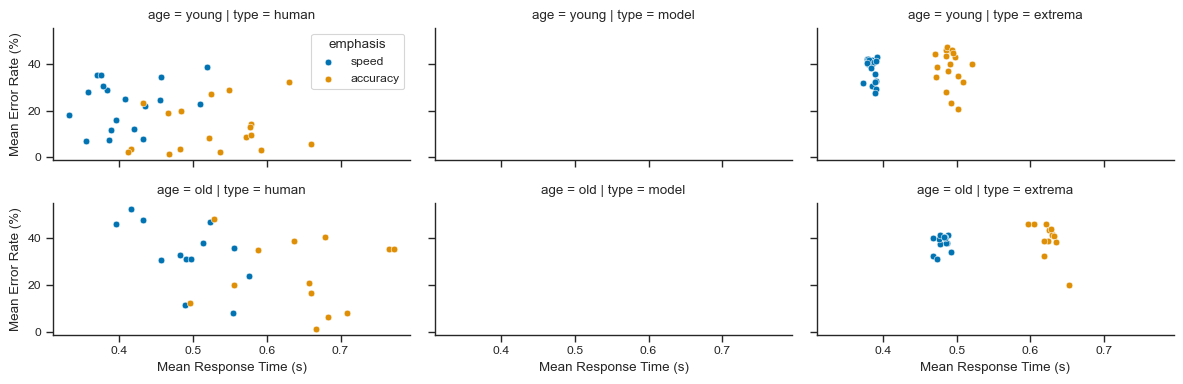

In [21]:
plot_SAT("forstmann_test", "forstmann2011", "forstmann_june30extrema")

In [26]:
# plot_RTs_individual("forstmann_july1one", "forstmann2011", "forstmann_june30extrema", bins=np.arange(0.0, 1.6, 0.05))